In [1]:
import torch
import torchvision.transforms.v2 as v2
from segdac_dev.data.sa1b.data_module import Sa1bDataModule
from segdac_dev.data.sa1b.dataset import Sa1bDataset
from segdac_dev.data.sa1b.dataset import OptimizedSa1bDataset
from pathlib import Path

In [3]:
preprocess_transform = v2.Compose([v2.Resize((1024,1024))])
sample_transform = v2.Compose([v2.Resize((224,224)), v2.ToDtype(dtype=torch.float32, scale=True)])

In [11]:
x_files = sorted(list(Path("../datasets/sa1b/").glob("*.jpg")))[:10]
y_files = sorted(list(Path("../datasets/sa1b/").glob("*.json")))[:10]
dataset = Sa1bDataset(x_files, y_files, preprocess_transform, return_image=False)

optimizable_dataset = Sa1bDataset(x_files, y_files, preprocess_transform, return_image=True)
optimized_dataset = optimizable_dataset.create_empty_optimized_dataset(transform=sample_transform)
optimized_dataset.load_from_dataset(optimizable_dataset, image_batch_size=16, num_workers=0)

100%|██████████| 755/755 [00:06<00:00, 116.59it/s]


In [4]:
optimized_data_module = Sa1bDataModule(
    data_folder="../datasets/sa1b/",
    seed=42,
    train_batch_size=16,
    val_batch_size=8,
    test_batch_size=8,
    val_split=0.25,
    test_split=0.2,
    train_transform=sample_transform,
    eval_transform=sample_transform,
    data_loader_num_workers=0,
    use_optimized_dataset=True,
    preprocess_transform=preprocess_transform,
)
unoptimized_data_module = Sa1bDataModule(
    data_folder="../datasets/sa1b/",
    seed=42,
    train_batch_size=16,
    val_batch_size=8,
    test_batch_size=8,
    val_split=0.25,
    test_split=0.2,
    train_transform=sample_transform,
    eval_transform=sample_transform,
    data_loader_num_workers=0,
    use_optimized_dataset=False,
    preprocess_transform=preprocess_transform,
)

In [5]:
optimized_data_module.create_datasets()

100%|██████████| 85/85 [00:00<00:00, 114.82it/s]


In [6]:
unoptimized_data_module.create_datasets()

In [7]:
train_dataloader = optimized_data_module.train_dataloader()
val_dataloader = optimized_data_module.val_dataloader()
test_dataloader = optimized_data_module.test_dataloader()

In [8]:
for train_batch in train_dataloader:
    print("train_batch: ")
    print(train_batch)
    break

for val_batch in val_dataloader:
    print("val_batch: ")      
    print(val_batch)
    break

for test_batch in test_dataloader:
    print("test_batch: ")
    print(test_batch)
    break

train_batch: 
TensorDict(
    fields={
        binary_masks: Tensor(shape=torch.Size([539, 1, 224, 224]), device=cpu, dtype=torch.uint8, is_shared=False),
        image_ids: Tensor(shape=torch.Size([539]), device=cpu, dtype=torch.int64, is_shared=False),
        rgb_segments: Tensor(shape=torch.Size([539, 3, 224, 224]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([539]),
    device=cpu,
    is_shared=False)
val_batch: 
TensorDict(
    fields={
        binary_masks: Tensor(shape=torch.Size([131, 1, 224, 224]), device=cpu, dtype=torch.uint8, is_shared=False),
        image_ids: Tensor(shape=torch.Size([131]), device=cpu, dtype=torch.int64, is_shared=False),
        rgb_segments: Tensor(shape=torch.Size([131, 3, 224, 224]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([131]),
    device=cpu,
    is_shared=False)
test_batch: 
TensorDict(
    fields={
        binary_masks: Tensor(shape=torch.Size([85, 1, 224, 224]), device=c

In [9]:
import time
import seaborn as sns
import matplotlib.pyplot as plt


def benchmark_dataset_read(dataset, n: int = 100) -> float:
    start = time.perf_counter()
    for i in range(n):
        data = dataset[i]
        del data
    end = time.perf_counter()
    avg_time = (end - start) / n
    print(f"Avg read time: {avg_time}s")
    return avg_time


def benchmark_dataloader_read(dataloader, n: int = 100) -> float:
    start = time.perf_counter()
    i = 0
    for batch in dataloader:
        i += 1
        del batch
        if i == n:
            break
    end = time.perf_counter()
    avg_time = (end - start) / n
    print(f"Avg read time: {avg_time}s")
    return avg_time


def plot_dataset_read_times(
    dataset_result: float, optimized_dataset_result: float, n: int
):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=(10, 10))

    x_labels = ["Unoptimized Dataset", "Optimized Dataset"]
    y_values = [dataset_result, optimized_dataset_result]

    bars = ax.bar(x_labels, y_values, color=sns.color_palette("muted"))

    ax.set_xlabel("Dataset Type", fontsize=14)
    ax.set_ylabel("Average Time (seconds)", fontsize=14)
    ax.set_title(f"Dataset Single Sample Average Read Time (n={n})", fontsize=16)

    for bar, value in zip(bars, y_values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{value:.5f}",
            ha="center",
            va="bottom",
            fontsize=12,
        )

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.5f}"))

    plt.show()


def plot_dataloader_read_times(
    dataloader_result: float,
    optimized_dataloader_result: float,
    batch_size: int,
    n: int,
    num_workers: int,
):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=(10, 10))

    x_labels = ["Unoptimized DataLoader", "Optimized DataLoader"]
    y_values = [dataloader_result, optimized_dataloader_result]

    bars = ax.bar(x_labels, y_values, color=sns.color_palette("muted"))

    ax.set_xlabel("Dataset Type", fontsize=14)
    ax.set_ylabel("Average Time (seconds)", fontsize=14)
    ax.set_title(
        f"Average Batch Load Time (n={n}, 1 batch = segments from {batch_size} images, num_workers={num_workers})",
        fontsize=16,
    )

    for bar, value in zip(bars, y_values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{value:.5f}",
            ha="center",
            va="bottom",
            fontsize=12,
        )

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.5f}"))

    plt.show()


n = 150

Avg read time: 0.022741689756512643s
Avg read time: 0.0009731915593147278s


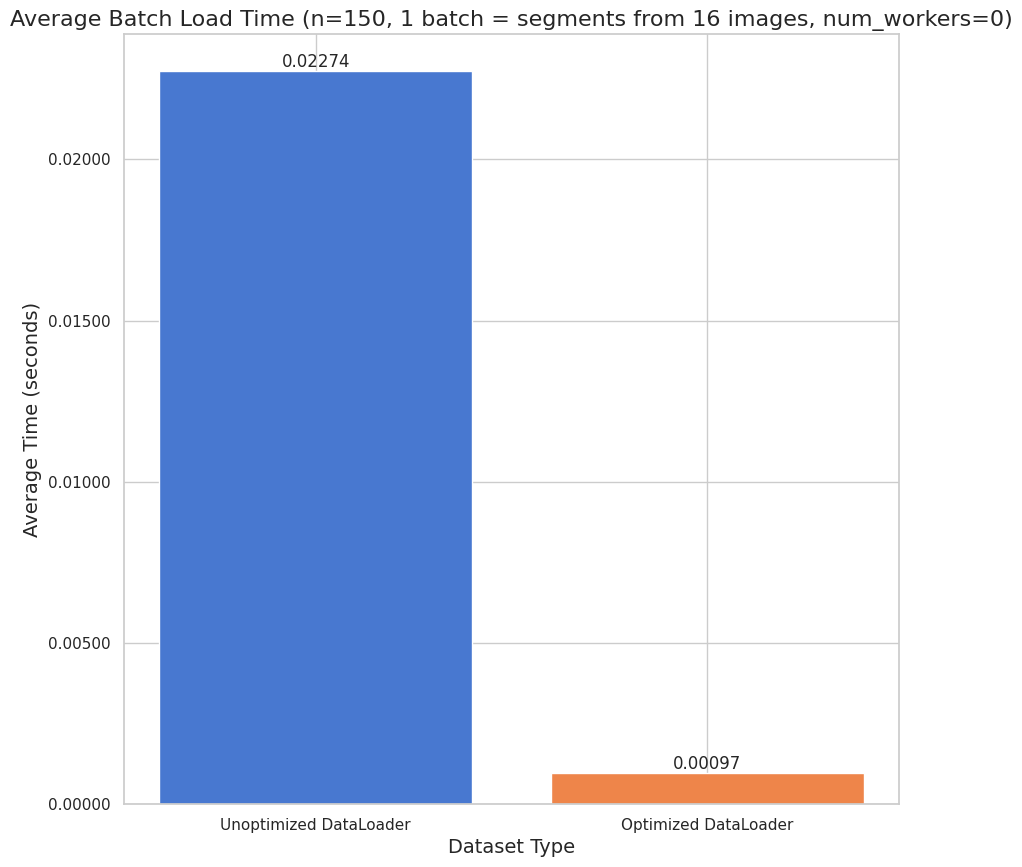

In [10]:
unoptimized_dataloader = unoptimized_data_module.train_dataloader()
optimized_dataloader = optimized_data_module.train_dataloader()

unoptimized_dl_read = benchmark_dataloader_read(dataloader=unoptimized_dataloader, n=n)
optimized_dl_read = benchmark_dataloader_read(dataloader=optimized_dataloader, n=n)
plot_dataloader_read_times(
    dataloader_result=unoptimized_dl_read,
    optimized_dataloader_result=optimized_dl_read,
    batch_size=unoptimized_data_module.train_batch_size,
    n=n,
    num_workers=unoptimized_dataloader.num_workers,
)

Avg read time: 0.4847959751884143s
Avg read time: 0.010240053137143454s


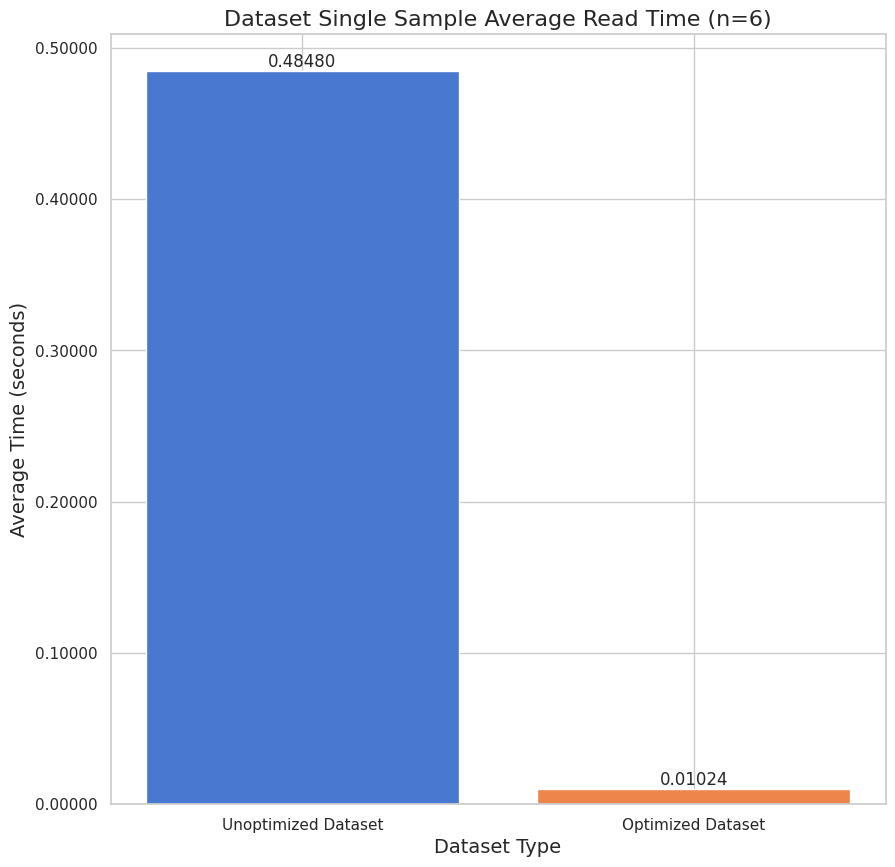

In [ ]:
unoptimized_ds_read = benchmark_dataset_read(dataset=unoptimized_dataloader.dataset, n=n)
optimized_ds_read = benchmark_dataset_read(dataset=optimized_dataloader.dataset, n=n)

plot_dataset_read_times(unoptimized_ds_read, optimized_ds_read, n)